# ASTR 400B Galaxy Project - Movie Showing Eventual Fate of Sun-Like Stars
#### Version 3.0

# High level project breakdown
The topic of this research project is to determine the eventual fate of Stars like the Sun in the disk of M31 and M33. Here, Sun-like stars are defined to be those at a similar distance from the galactic center (~8 pc), with a circular speed calculated using the enclosed mass at that radius, and with some maximum velocity out of the galactic plane. Specifically, I want to determine where these stars end up relative to the merger remnant and visualize his using a movie of the simulation.

Here, I specifically attempt an initial selection of Sun-like particles using the parameters mentioned above. I'll then make a movie highlighting the migration of these particles over time. This movie will include frames from all snaps from the simulation (0-800).

Additionally, I want to examine the distance of Sun-like particles in M31 from the M31 center of mass over time. To do this, I will create histograms which display the number of particles at a range of distances over time, again using all snaps from the simulation. These histograms will then be stitched together into a new video.

In [1]:
import numpy as np

import astropy.units as u
from astropy.constants import G

import matplotlib.pyplot as plt

from ReadFile import Read
from CenterOfMass2 import CenterOfMass
from OrbitCOM import OrbitCOM
from MassProfile import MassProfile
%matplotlib inline

## 1. Select Sun-Like Stars in M31 and M33
#### 1.1 Set radial distance of Sun from ISRF and maximum z-velocity (out of plane velocity). Define tolerance values to define an acceptable range of values to select Sun-like stars.

In [2]:
# For an initial estimate for selecting Sun-like particles, I use a tolerance of 10% (plus or minus 0.1 * parameter)
sun_r = 8.29 # Distance of Sun from MW center in kpc (van der Marel+ 2012b)
max_z_velocity = 100 # all particles with z-velocity < 30 km/s, condition from (van der Marel+ 2012a)

# tuple storing radial distance of sun from galactic center (kpc) and maximum allowed out-of-plane velocity (km/s)
sun_parameters = (sun_r, max_z_velocity) 
sun_tolerances = (0.1, 0.1) # fractional tolerance values for defining sun-like stars
# first tolerance value is on radial distance, second is on calculated circular speed

#### 1.2 Import function to rotate the frame of M31 and M33 so that edge-on and face-on components of their components can be analyzed (following Lab 7)

In [3]:
def RotateFrame(posI,velI): # function to rotate frame of M31/M33, from in-class lab 7
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

#### 1.3 Using previously developed codes, get the radial distance of particles from the COM position (get COM from CenterOfMass.py), circular speeds at that radii (analytic v_circ from enclosed mass is from HW 6, actual tangential velocity may need new codes), and the z-component of the position (distance from the galactic plane, new code) 

In [4]:
snap_start = 0 # starting snap number
snap_end = 800 # ending snap number
increment = 1 # increment between snaps for plotting purposes
MW_path = 'D:/'
M31_path = 'D:/'
M33_path = 'D:/' # path to directory containing orbit information

In [12]:
### Get the center-of-mass positions and velocities of all 3 galaxies at all snaps
OrbitCOM('MW', snap_start, snap_end+1, increment, MW_path) # MW COM file
OrbitCOM('M31', snap_start, snap_end+1, increment, M31_path) # M31 COM file
OrbitCOM('M33', snap_start, snap_end+1, increment, M33_path) # M33 COM file

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776


In [5]:
MW_orbit = np.genfromtxt('Orbit_MW.txt', names=True) # Read in MW COM file
x_MW = MW_orbit['x'] # x position of MW COM
y_MW = MW_orbit['y'] # y position of MW COM
z_MW = MW_orbit['z'] # z position of MW COM

In [6]:
M31_orbit = np.genfromtxt('Orbit_M31.txt', names=True) # Read in M31 COM file
x_M31 = M31_orbit['x'] # x position of M31 COM
y_M31 = M31_orbit['y'] # y position of M31 COM
z_M31 = M31_orbit['z'] # z position of M31 COM

In [7]:
M33_orbit = np.genfromtxt('Orbit_M33.txt', names=True) # Read in M33 COM file
x_M33 = M33_orbit['x'] # x position of M33 COM
y_M33 = M33_orbit['y'] # y position of M33 COM
z_M33 = M33_orbit['z'] # z position of M33 COM

#### 1.4 Use the previously defined acceptable ranges to get the indices of all the disk particles that are within the tolerance for the three values

In [8]:
def sunlike_stars(path, galaxy, snap, parameters, tolerances):
    ''' Function to find indices of Sun-like stars in the MW, M31, or M33. These stars are defined
    as ones which are a specified radial distance away from their galactic center and with circular
    speeds which match the one calculated by the enclosed mass within that radius, within supplied
    tolerances. There is also a cutoff for maximum out-of-plane velocity (van der Marel+ 2012a).
    
    INPUTS
    ------
    path: `str`
        file path prefix of location of simulation data for galaxy
    galaxy: `str`
        name of galaxy to find indices for ('MW', 'M31', 'M33')
    snap: `int`
        snap number to find sunlike star indices at
    parameters: `tuple`
        tuple containing sun distance from galactic center (kpc) and maximum out-of-plane velocity (km/s)
    sun_tolerances: `tuple`
        fractional allowed tolerances in the radial distance from the galactic center and circular speed
        
    RETURNS
    -------
    indices: `numpy array`
        array of indices of sun-like stars in the given galaxy
    '''
    
    sun_r, max_z_velocity = sun_parameters # unpack tuple of sun parameters
    sun_r_tol, circular_speed_tol = sun_tolerances # unpack tolerances
    
    mass_profile = MassProfile(galaxy, snap)
    calculated_circular_speed = mass_profile.circularVelocityTotal(sun_r).value
    
    ilbl = '000' + str(snap) # add a string of the filenumber to the value “000”
    ilbl = ilbl[-3:] # remove all but the last 3 digits
    # compose filename for each snap number being iterated
    filename = path + f'{galaxy}/' + '%s_'%(galaxy) + ilbl + '.txt' 
    
    COMD = CenterOfMass(filename, 2) # COM object of galaxy using disk particles
    
    COMP = COMD.COM_P(0.1) # get position of COM at this snap
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2]) # velocity of COM at this snap
    
    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 

    # Determine velocities of disk particles relative to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 

    # Vectors for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T

    # position and velocity of disk particles after rotating the frame of reference so that
    # the z-axis lines up with the total galaxy angular momentum
    r_rotated, v_rotated = RotateFrame(r, v) 
    
    r_to_COM = np.sqrt(r_rotated[:,0]**2 + r_rotated[:,1]**2) # x-y distance of particles from COM
    circular_speed = np.sqrt(v_rotated[:,0]**2 + v_rotated[:,1]**2) # x-y speed of disk particles
    
    # all particles with sun-like radius within specified tolerance
    radial_indices = np.where(abs((r_to_COM-sun_r)/sun_r) < sun_r_tol)
    # all particles with sun-like circular speed within specified tolerance
    circular_speed_indices = np.where(abs((circular_speed-calculated_circular_speed)/calculated_circular_speed) \
                                      < circular_speed_tol)
    # all particles with z-velocity < 30 km/s within tolerance, condition from (van der Marel+ 2012a)
    z_indices = np.where(abs(v[:,2]) < max_z_velocity) 
    
    indices = np.intersect1d(radial_indices, z_indices) # radius and z-velocity cutoffs
    indices = np.intersect1d(indices, circular_speed_indices) # add circular speed cutoff for MW/M31
    
    return indices

In [9]:
MW_sunlike_indices = sunlike_stars(MW_path, 'MW', 0, sun_parameters, sun_tolerances) # sun-like particle indices in MW
M31_sunlike_indices = sunlike_stars(M31_path, 'M31', 0, sun_parameters, sun_tolerances) # sun-like particle indices in M31
M33_sunlike_indices = sunlike_stars(M33_path, 'M33', 0, sun_parameters, sun_tolerances) # sun-like particle indices in M33

## 2. Visualize trajectory of selected stars
#### 2.1 Get positions of all particles at each snapshot relative to the M31 COM. Create frame-by-frame plots at eachsnap number, plotting the sun-like particles in a different color.

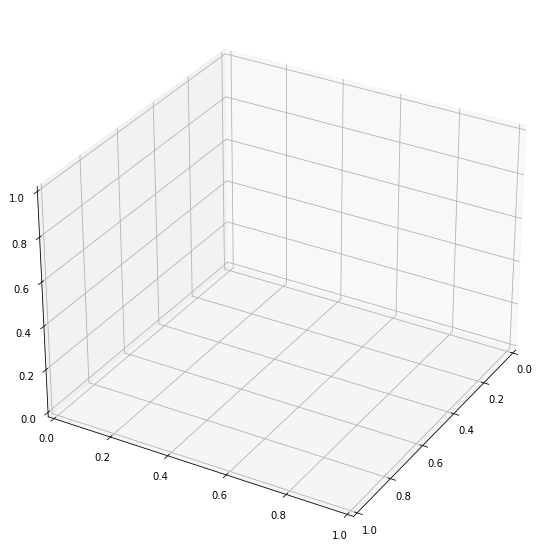

In [10]:
snap_end = 400
ax = plt.figure(figsize=(10,10)).add_subplot(projection="3d",computed_zorder=False)
for index, i in enumerate(range(snap_start, snap_end+1, increment)):
    index = (index + snap_start)*increment # correct index for starting at nonzero snap_start
    ilbl = '000' + str(i) # add a string of the filenumber to the value “000”
    ilbl = ilbl[-3:] # remove all but the last 3 digits
    
    ### Milky Way Plotting
    filename1 = MW_path + 'MW/MW_' + ilbl + '.txt' # MW filename including snap
    time, total, data1 = Read(filename1) # read in the datafile
    disk_indices1 = np.where(data1['type'] == 2) # get all disk particle indices
    data1 = data1[disk_indices1] # data for all disk particles
    x1 = data1['x'] - M31_orbit['x'][index] # x position for MW disk particles relative to M31 COM
    y1 = data1['y'] - M31_orbit['y'][index] # y position for MW disk particles relative to M31 COM
    z1 = data1['z'] - M31_orbit['z'][index] # z position for MW disk particles relative to M31 COM
    ax.scatter(x1, y1, z1, s=0.1, marker='.', c='green', zorder=3) # plot MW disk particles
    # Optionally, one can include MW sun-like particles in plot. Here, I leave it out.
#     ax.scatter(x1[MW_sunlike_indices], y1[MW_sunlike_indices],\
#                z1[MW_sunlike_indices], s=0.1, marker='.', c='black', zorder=5)
    
    ### M31 Plotting
    filename2 = M31_path + 'M31/M31_' + ilbl + '.txt' # M31 filename including snap
    time, total, data2 = Read(filename2) # read in the datafile
    disk_indices2 = np.where(data2['type'] == 2) # get all disk particle indices
    data2 = data2[disk_indices2] # data for all disk particles
    x2 = data2['x'] - M31_orbit['x'][index] # x position for M31 disk particles relative to M31 COM
    y2 = data2['y'] - M31_orbit['y'][index] # y position for M31 disk particles relative to M31 COM
    z2 = data2['z'] - M31_orbit['z'][index] # z position for M31 disk particles relative to M31 COM
    ax.scatter(x2, y2, z2, s=0.01, marker='.', c='orange') # plot M31 disk particles
    ax.scatter(x2[M31_sunlike_indices], y2[M31_sunlike_indices], \
               z2[M31_sunlike_indices], s=1, c='black') # plot M31 sun-like particles
    
    ### M33 Plotting
    filename3 = M33_path + 'M33/M33_' + ilbl + '.txt' # M33 filename including snap
    time, total, data3 = Read(filename3) # read in the datafile
    disk_indices3 = np.where(data3['type'] == 2)
    data3 = data3[disk_indices3] # data for all disk particles
    x3 = data3['x'] - M31_orbit['x'][index] # x position for M33 disk particles relative to M31 COM
    y3 = data3['y'] - M31_orbit['y'][index] # y position for M33 disk particles relative to M31 COM
    z3 = data3['z'] - M31_orbit['z'][index] # z position for M33 disk particles relative to M31 COM
    ax.scatter(x3, y3, z3, s=0.01, marker='.', c='red') # plot M33 disk particles
    ax.scatter(x3[M33_sunlike_indices], y3[M33_sunlike_indices],\
               z3[M33_sunlike_indices], s=0.1, c='black') # plot M33 sun-like particles
    
    ax.grid(True)
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.set_zlim(-50, 50)
    ax.view_init(30, 30)
    
    plt.savefig(f'images2/M31_COM_{index}.png') # save plot as image
    ax.clear() # clear plot to get the next frame ready

#### 2.3 Assemble frames in video editing software (Adobe Premiere)
Video included in project folder (M31 COM Movie 1.mp4)

## 3. Radial Migration of Sunlike Stars in M31
#### 3.1 Create histograms showing distance of M31 sunlike stars from M31 COM at each snap

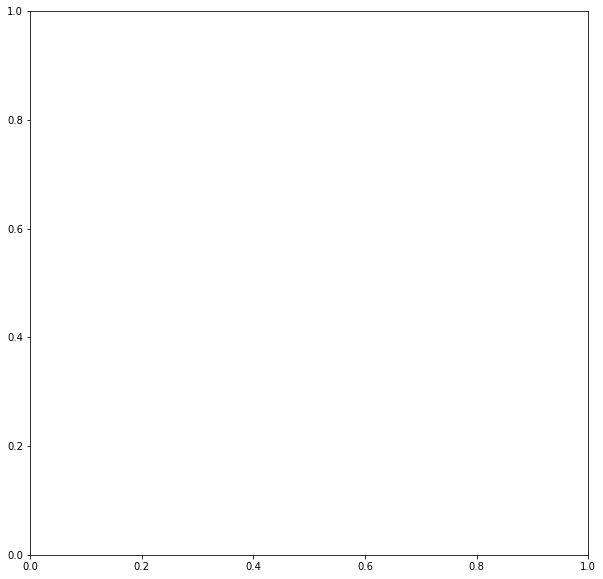

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

for index, i in enumerate(range(snap_start, snap_end+1, increment)):
    index = (index + snap_start)*increment # correct index for starting at nonzero snap_start
    ilbl = '000' + str(i) # add a string of the filenumber to the value “000”
    ilbl = ilbl[-3:] # remove all but the last 3 digits
    
    ### Plot histograms of radial position of M31 sunlike particles
    filename = M31_path + 'M31/M31_' + ilbl + '.txt' # M31 filename including snap
    time, total, data = Read(filename) # read in the datafile
    disk_indices = np.where(data['type'] == 2) # get all disk particle indices
    data = data[disk_indices] # data for all disk particles
    x = data['x'] - M31_orbit['x'][index] # x position for M31 disk particles relative to M31 COM
    y = data['y'] - M31_orbit['y'][index] # y position for M31 disk particles relative to M31 COM
    z = data['z'] - M31_orbit['z'][index] # z position for M31 disk particles relative to M31 COM
    r = np.sqrt(x**2 + y**2 + z**2)
    ax.hist(r[M31_sunlike_indices], bins=np.linspace(0, 60, 100)) # plot M31 sun-like particles
    ax.set_title(f'Number of M31 Sunlike Particles at Given Distances from M31 COM (kpc) at Snap {i}')
    ax.set_xlabel('Distance from COM [kpc]')
    ax.set_ylabel('Counts')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 250)    
    
    
    plt.savefig(f'histograms2/M31_migration_histogram_{index}.png') # save plot as image
    ax.clear() # clear plot to get the next frame ready

#### 2.3 Assemble frames in video editing software (Adobe Premiere)
First draft of video included in project folder (M31 Histogram Video (Work in Progress).mp4)

In [ ]:
threshold_VI = observed_VI[threshold_indices]
qso_threshold_indices = np.where(threshold_VI == 'QSO')
threshold_ID = observed_ID[qso_threshold_indices]
threshold_RA = observed_RA[qso_threshold_indices]
threshold_DEC = observed_DEC[qso_threshold_indices]
threshold_TILEID = observed_TILEID[qso_threshold_indices]
threshold_NIGHT = observed_NIGHT[qso_threshold_indices]
threshold_VI = observed_VI[qso_threshold_indices]
threshold_Z = observed_Z[qso_threshold_indices]